In [11]:
import numpy as np
import random
from math import inf as infinity
import math
import copy

BOARD_SIZE = int(input("Enter the size of the board (4 or 5): "))
many_gamea = int(input("Enter the number of games: "))
Q_LEARNING = 1
OPPONENT = 2

Q_LEARNING_SCORE = 0
OPPONENT_SCORE = 0

q_values = {}

board = [[0 for _ in range(BOARD_SIZE)] for _ in range(BOARD_SIZE)]

def wins(state, player):
    for i in range(BOARD_SIZE):
        if all(state[i][j] == player for j in range(BOARD_SIZE)):
            return True
        if all(state[j][i] == player for j in range(BOARD_SIZE)):
            return True
    if all(state[i][i] == player for i in range(BOARD_SIZE)):
        return True
    if all(state[i][BOARD_SIZE - 1 - i] == player for i in range(BOARD_SIZE)):
        return True
    return False

def empty_cells(state):
    cells = []
    for i in range(BOARD_SIZE):
        for j in range(BOARD_SIZE):
            if state[i][j] == 0:
                cells.append((i, j))
    return cells

def valid_move(x, y):
    return 0 <= x < BOARD_SIZE and 0 <= y < BOARD_SIZE and board[x][y] == 0

def set_move(x, y, player):
    if valid_move(x, y):
        board[x][y] = player
        return True
    return False

def end_game(state):
    return wins(state, Q_LEARNING) or wins(state, OPPONENT)

def reward_3(state, player):
    reward = 0

    # Check rows
    for row in state:
        for i in range(len(row) - 2):
            if all(row[i + j] == player for j in range(3)):
                reward += 45

    # Check columns
    for i in range(len(state)):
        for j in range(len(state) - 2):
            if all(state[j + k][i] == player for k in range(3)):
                reward += 45

    # Check diagonals
    for i in range(len(state) - 2):
        for j in range(len(state) - 2):
            if all(state[i + k][j + k] == player for k in range(3)):
                reward += 45
            if all(state[i + k][len(state) - 1 - j - k] == player for k in range(3)):
                reward += 45

    return reward

def reward_2(state, player):
    reward = 0

    # Check rows
    for row in state:
        for i in range(len(row) - 1):
            if all(row[i + j] == player for j in range(2)):
                reward += 20

    # Check columns
    for i in range(len(state)):
        for j in range(len(state) - 1):
            if all(state[j + k][i] == player for k in range(2)):
                reward += 20

    # Check diagonals
    for i in range(len(state) - 1):
        for j in range(len(state) - 1):
            if all(state[i + k][j + k] == player for k in range(2)):
                reward += 20
            if all(state[i + k][len(state) - 1 - j - k] == player for k in range(2)):
                reward += 20

    return reward

def reward_3_opponent(state, player, opponent):
    reward = 0

    # Check rows
    for row in state:
        for i in range(len(row) - 2):
            if all(row[i + j] == player for j in range(3)):
                top_blocked = i > 0 and row[i - 1] == opponent
                right_blocked = i < len(row) - 3 and row[i + 3] == opponent
                if not top_blocked or right_blocked:
                    reward += 60

    # Check columns
    for i in range(len(state)):
        for j in range(len(state) - 2):
            if all(state[j + k][i] == player for k in range(3)):
                top_blocked = j > 0 and state[j - 1][i] == opponent
                bottom_blocked = j < len(state) - 3 and state[j + 3][i] == opponent
                if not top_blocked or bottom_blocked:
                    reward += 60

    # Check diagonals
    for i in range(len(state) - 2):
        for j in range(len(state) - 2):
            if all(state[i + k][j + k] == player for k in range(3)):
                top_blocked = i > 0 and j > 0 and state[i - 1][j - 1] == opponent
                bottom_blocked = i < len(state) - 3 and j < len(state) - 3 and state[i + 3][j + 3] == opponent
                if not top_blocked or bottom_blocked:
                    reward += 60
            if all(state[i + k][len(state) - 1 - j - k] == player for k in range(3)):
                top_blocked = i > 0 and j < len(state) - 1 and state[i - 1][j + 1] == opponent
                bottom_blocked = i < len(state) - 3 and j > 1 and state[i + 3][j - 3] == opponent
                if not top_blocked or bottom_blocked:
                    reward += 60

    return reward

def reward_2_opponent(state, player, opponent):
    reward = 0

    # Check rows
    for row in state:
        for i in range(len(row) - 1):
            if all(row[i + j] == player for j in range(2)):
                top_blocked = i > 0 and row[i - 1] == opponent
                right_blocked = i < len(row) - 2 and row[i + 2] == opponent
                if not top_blocked or right_blocked:
                    reward += 40

    # Check columns
    for i in range(len(state)):
        for j in range(len(state) - 1):
            if all(state[j + k][i] == player for k in range(2)):
                top_blocked = j > 0 and state[j - 1][i] == opponent
                bottom_blocked = j < len(state) - 2 and state[j + 2][i] == opponent
                if not top_blocked or bottom_blocked:
                    reward += 40

    # Check diagonals
    for i in range(len(state) - 1):
        for j in range(len(state) - 1):
            if all(state[i + k][j + k] == player for k in range(2)):
                top_blocked = i > 0 and j > 0 and state[i - 1][j - 1] == opponent
                bottom_blocked = i < len(state) - 2 and j < len(state) - 2 and state[i + 2][j + 2] == opponent
                if not top_blocked or bottom_blocked:
                    reward += 40
            if all(state[i + k][len(state) - 1 - j - k] == player for k in range(2)):
                top_blocked = i > 0 and j < len(state) - 1 and state[i - 1][j + 1] == opponent
                bottom_blocked = i < len(state) - 2 and j > 0 and state[i + 2][j - 2] == opponent
                if not top_blocked or bottom_blocked:
                    reward += 40

    return reward

def reward_3_open(state, player):
    reward = 0

    # Check rows
    for row in state:
        for i in range(len(row) - 2):
            if all(row[i + j] == player for j in range(3)):
                if (i - 1 >= 0 and row[i - 1] == 0) or (i + 3 < len(row) and row[i + 3] == 0):
                    reward += 300

    # Check columns
    for i in range(len(state)):
        for j in range(len(state) - 2):
            if all(state[j + k][i] == player for k in range(3)):
                if (j - 1 >= 0 and state[j - 1][i] == 0) or (j + 3 < len(state) and state[j + 3][i] == 0):
                    reward += 300

    # Check diagonals
    for i in range(len(state) - 2):
        for j in range(len(state) - 2):
            if all(state[i + k][j + k] == player for k in range(3)):
                if (i - 1 >= 0 and j - 1 >= 0 and state[i - 1][j - 1] == 0) or (i + 3 < len(state) and j + 3 < len(state) and state[i + 3][j + 3] == 0):
                    reward += 300
            if all(state[i + k][len(state) - 1 - j - k] == player for k in range(3)):
                if (i - 1 >= 0 and j + 1 < len(state) and state[i - 1][j + 1] == 0) or (i + 3 < len(state) and j > 1 and state[i + 3][j - 3] == 0):
                    reward += 300

    return reward

def reward_4_open(state, player):
    reward = 0

    # Check rows
    for row in state:
        for i in range(len(row) - 3):
            if all(row[i + k] == player for k in range(4)):
                if (i - 1 >= 0 and row[i - 1] == 0) and (i + 4 < len(row) and row[i + 4] == 0):
                    reward += 1000

    # Check columns
    for i in range(len(state)):
        for j in range(len(state) - 3):
            if all(state[j + k][i] == player for k in range(4)):
                if (j - 1 >= 0 and state[j - 1][i] == 0) and (j + 4 < len(state) and state[j + 4][i] == 0):
                    reward += 1000

    # Check diagonals
    for i in range(len(state) - 3):
        for j in range(len(state) - 3):
            if all(state[i + k][j + k] == player for k in range(4)):
                if (i - 1 >= 0 and j - 1 >= 0 and state[i - 1][j - 1] == 0) and (i + 4 < len(state) and j + 4 < len(state) and state[i + 4][j + 4] == 0):
                    reward += 1000
            if all(state[i + k][len(state) - 1 - j - k] == player for k in range(4)):
                if (i - 1 >= 0 and j + 1 < len(state) and state[i - 1][j + 1] == 0) and (i + 4 < len(state) and j > 2 and state[i + 4][j - 4] == 0):
                    reward += 1000

    return reward

def reward_n_open(state, player):
    # Check rows
    for row in state:
        for i in range(len(row) - BOARD_SIZE + 1):
            if all(row[i + k] == player for k in range(BOARD_SIZE)):
                if (i - 1 >= 0 and row[i - 1] == 0) and (i + BOARD_SIZE < len(row) and row[i + BOARD_SIZE] == 0):
                    return True

    # Check columns
    for i in range(len(state)):
        for j in range(len(state) - BOARD_SIZE + 1):
            if all(state[j + k][i] == player for k in range(BOARD_SIZE)):
                if (j - 1 >= 0 and state[j - 1][i] == 0) and (j + BOARD_SIZE < len(state) and state[j + BOARD_SIZE][i] == 0):
                    return True

    # Check diagonals
    for i in range(len(state) - BOARD_SIZE + 1):
        for j in range(len(state) - BOARD_SIZE + 1):
            if all(state[i + k][j + k] == player for k in range(BOARD_SIZE)):
                if (i - 1 >= 0 and j - 1 >= 0 and state[i - 1][j - 1] == 0) and (i + BOARD_SIZE < len(state) and j + BOARD_SIZE < len(state) and state[i + BOARD_SIZE][j + BOARD_SIZE] == 0):
                    return True
            if all(state[i + k][len(state) - 1 - j - k] == player for k in range(BOARD_SIZE)):
                if (i - 1 >= 0 and j + 1 < len(state) and state[i - 1][j + 1] == 0) and (i + BOARD_SIZE < len(state) and j > BOARD_SIZE - 1 and state[i + BOARD_SIZE][j - BOARD_SIZE] == 0):
                    return True
    return False

def random_move(state):
    return random.choice(empty_cells(state))

def evaluate(state):
    reward = 0
    if wins(state, Q_LEARNING):
        reward += 2000
    if wins(state, OPPONENT):
        reward -= 1500
    if reward_n_open(state, Q_LEARNING):
        reward += 800
    if reward_n_open(state, OPPONENT):
        reward -= 600
    reward += reward_4_open(state, Q_LEARNING)
    reward -= reward_4_open(state, OPPONENT)
    reward += reward_3_open(state, Q_LEARNING)
    reward -= reward_3_open(state, OPPONENT)
    reward += reward_3(state, Q_LEARNING)
    reward -= reward_3(state, OPPONENT)
    reward += reward_2(state, Q_LEARNING)
    reward -= reward_2(state, OPPONENT)
    reward += reward_3_opponent(state, Q_LEARNING, OPPONENT)
    reward -= reward_3_opponent(state, OPPONENT, Q_LEARNING)
    reward += reward_2_opponent(state, Q_LEARNING, OPPONENT)
    reward -= reward_2_opponent(state, OPPONENT, Q_LEARNING)
    return reward

def render(state, c_choice, h_choice):
    chars = {
        0: ' ',
        Q_LEARNING: c_choice,
        OPPONENT: h_choice
    }
    str_line = '-' + '----' * BOARD_SIZE
    print(str_line)
    for i in range(BOARD_SIZE):
        print('|', end='')
        for j in range(BOARD_SIZE):
            print(' ' + chars[state[i][j]] + ' |', end='')
        print()
        print(str_line)

def encode_state(state):
    return tuple(tuple(row) for row in state)

def copy_boad(state):
    return copy.deepcopy(state)

def check_winner(state):
    global Q_LEARNING_SCORE, OPPONENT_SCORE
    if wins(state, Q_LEARNING):
        print('Q Learning wins!')
        Q_LEARNING_SCORE += 1
    elif wins(state, OPPONENT):
        print('Opponent wins!')
        OPPONENT_SCORE += 1
    else:
        print("It's a draw!")

def reset_board():
    global board
    board = [[0 for _ in range(BOARD_SIZE)] for _ in range(BOARD_SIZE)]

def state_copy(state):
    return [list(row) for row in state]

def correct_state(state):
    count_1 = 0
    count_2 = 0

    for row in state:
        count_1 += row.count(1)
        count_2 += row.count(2)

    return count_1 != count_2

def backup_policy(state):
    board_cp = copy_boad(state)

    best_move = None
    best_score = -infinity

    move = empty_cells(board_cp)
    for m in move:
        x, y = m[0], m[1]
        board_cp[x][y] = Q_LEARNING
        score = evaluate(board_cp)
        board_cp[x][y] = 0
        if score > best_score:
            best_score = score
            best_move = m

    return best_move

def q_learning_policy(epsilon, state):
    actions = empty_cells(state)
    if random.random() < epsilon:
        # print('exploratory move')
        return random.choice(actions)
    else:
        encoded_state = encode_state(state)
        filtered_q_values = {key: value for key, value in q_values.items() if key[0] == encoded_state}
        if filtered_q_values:
            # print('founded')
            max_value = max(filtered_q_values.values())
            max_actions = [key for key, value in filtered_q_values.items() if value == max_value]
            best_action = random.choice(max_actions)
            return [best_action[1], best_action[2]]
        else:
            # print('not found')
            return backup_policy(state)

Enter the size of the board (4 or 5): 5
Enter the number of games: 300


In [ ]:
def game_with_q_learning(c_choice, h_choice, episode, decay_rate=0.01, alpha=0.1, gamma=0.99):
    epsilon = 0.1 * math.e ** (-decay_rate * episode)
    print(f'current epsilon: {epsilon}')
    action = q_learning_policy(epsilon, board)
    while not end_game(board) and len(empty_cells(board)) > 0:
        x, y = action[0], action[1]
        tuple_action = (x, y)
        key = (encode_state(board), *tuple_action)

        # Cập nhật nước đi của Q Learning
        set_move(x, y, Q_LEARNING)
        reward = evaluate(board)
        render(board, c_choice, h_choice)

        if end_game(board) or len(empty_cells(board)) == 0:
            q_values[key] = q_values.get(key, 0) + alpha * (reward - q_values.get(key, 0))
            break

        move = random_move(board)
        set_move(move[0], move[1], OPPONENT)
        render(board, c_choice, h_choice)
        if end_game(board) or len(empty_cells(board)) == 0:
            q_values[key] = q_values.get(key, 0) + alpha * (reward - q_values.get(key, 0))
            break

        next_state = encode_state(board)
        possible_actions = empty_cells(board)
        max_next_qsa = max([q_values.get((next_state, action[0], action[1]), 0) for action in possible_actions])
        q_values[key] = q_values.get(key, 0) + alpha * (reward + gamma * max_next_qsa - q_values.get(key, 0))

        next_action = q_learning_policy(epsilon, board)
        action = next_action

    check_winner(board)
    reset_board()

In [7]:
def q_learning_vs_sarsa(c_choice, h_choice, episode, decay_rate=0.01, alpha=0.1, gamma=0.99):
    epsilon = 0.1 * math.e ** (-decay_rate * episode)
    action_q_learning = q_learning_policy(epsilon, board)
    action_sarsa = q_learning_policy(epsilon, board)
    current_turn = "q_learning"  # Bắt đầu bằng Q-learning
    while not end_game(board) and len(empty_cells(board)) > 0:
        if current_turn == "q_learning":
            # Q-learning chơi
            x, y = action_q_learning[0], action_q_learning[1]
            tuple_action = (x, y)
            key = (encode_state(board), *tuple_action)

            # Cập nhật nước đi của Q-learning
            set_move(x, y, Q_LEARNING)
            reward = evaluate(board)
            render(board, c_choice, h_choice)

            if end_game(board) or len(empty_cells(board)) == 0:
                q_values[key] = q_values.get(key, 0) + alpha * (reward - q_values.get(key, 0))
                break

            # Cập nhật Q-learning Q-value
            next_state = encode_state(board)
            possible_actions = empty_cells(board)
            max_next_qsa = max([q_values.get((next_state, action[0], action[1]), 0) for action in possible_actions])
            q_values[key] = q_values.get(key, 0) + alpha * (reward + gamma * max_next_qsa - q_values.get(key, 0))

            # Lấy hành động tiếp theo cho lượt sau của Q-learning
            action_q_learning = q_learning_policy(epsilon, board)

            # Chuyển lượt sang SARSA
            current_turn = "sarsa"

        elif current_turn == "sarsa":
            # SARSA chơi
            x, y = action_sarsa[0], action_sarsa[1]
            tuple_action = (x, y)
            key = (encode_state(board), *tuple_action)

            # Cập nhật nước đi của SARSA
            set_move(x, y, OPPONENT)
            reward = evaluate(board)
            render(board, c_choice, h_choice)

            if end_game(board) or len(empty_cells(board)) == 0:
                q_values[key] = q_values.get(key, 0) + alpha * (reward - q_values.get(key, 0))
                break

            # Lấy hành động tiếp theo theo chính sách SARSA
            next_action_sarsa = q_learning_policy(epsilon, board)
            next_key = (encode_state(board), next_action_sarsa[0], next_action_sarsa[1])
            next_qsa = q_values.get(next_key, 0)

            # Cập nhật SARSA Q-value
            q_values[key] = q_values.get(key, 0) + alpha * (reward + gamma * next_qsa - q_values.get(key, 0))

            # Chuyển lượt sang Q-learning
            action_sarsa = next_action_sarsa
            current_turn = "q_learning"

    check_winner(board)
    reset_board()

In [ ]:
def start_q_learning_vs_sarsa():
  global board
  h_choice = 'X'
  c_choice = 'O'
  for i in range(many_gamea):
    q_learning_vs_sarsa(c_choice, h_choice, i)
  print(f'final score: q_learning: {Q_LEARNING_SCORE} - sarsa: {OPPONENT_SCORE}')
  print(f"q_values's length: {len(q_values)}")

def start_q_learning_vs_random():
  global board
  h_choice = 'X'
  c_choice = 'O'
  for i in range(many_gamea):
    game_with_q_learning(c_choice, h_choice, i)
  print(f'final score: q_learning: {Q_LEARNING_SCORE} - random: {OPPONENT_SCORE}')
  print(f"q_values's length: {len(q_values)}")

In [ ]:
def main():
    start_q_learning_vs_sarsa()
    # start_q_learning_vs_random()

In [12]:
if __name__ == '__main__':
    main()

Streaming output truncated to the last 5000 lines.
---------------------
|   |   |   |   |   |
---------------------
---------------------
| O | O | O | X |   |
---------------------
| O | O | O |   |   |
---------------------
| O | O | O | X |   |
---------------------
| X |   | X |   |   |
---------------------
|   |   |   |   |   |
---------------------
---------------------
| O | O | O | X |   |
---------------------
| O | O | O |   |   |
---------------------
| O | O | O | X |   |
---------------------
| X |   | X |   |   |
---------------------
|   |   |   |   |   |
---------------------
---------------------
| O | O | O | X |   |
---------------------
| O | O | O |   |   |
---------------------
| O | O | O | X |   |
---------------------
| X |   | X |   |   |
---------------------
|   |   |   |   |   |
---------------------
---------------------
| O | O | O | X |   |
---------------------
| O | O | O |   |   |
---------------------
| O | O | O | X |   |
---------------------
| X

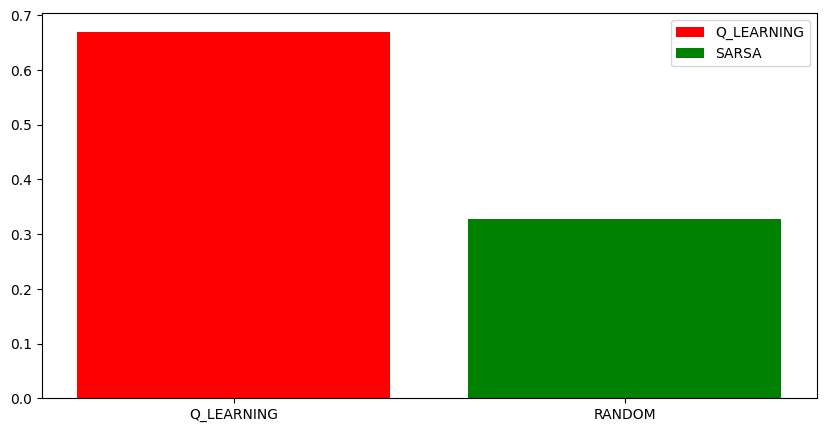

In [13]:
import matplotlib.pyplot as plt # Import the Matplotlib package
fig, ax = plt.subplots(figsize = (10,5))
x = ['Q_LEARNING', 'RANDOM']
y = [round(Q_LEARNING_SCORE / many_gamea,4) , round(OPPONENT_SCORE / many_gamea,4)]
colors = ['red', 'green']
plt.bar(x=x, height=y, label=['Q_LEARNING', 'SARSA'], color = colors)
plt.legend()
plt.show()